<a href="https://colab.research.google.com/github/elifohri/MADRE-Course/blob/main/ml_pipeline/week2/ml_pipeline_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Pipeline**

The aim of this class is to give you a **clear and practical understanding** of how a real machine-learning project is applied to **network intrusion detection systems**.

**This week’s focus:**

We are now moving from **data preparation** to the **modeling stage**, where we’ll apply **classification** (detecting attacks) techniques.

You will learn how to:
- Split the data into training and testing sets   
- Train baseline models (Logistic Regression)  
- Evaluate their performance   

By the end of this session, you’ll have a full, end-to-end ML workflow ready for intrusion detection analysis.

## 🔁 Recap from week 1: Data Preparation

In Week 1, we prepared the intrusion detection dataset for modeling. Here’s a brief recap from what was done step-by-step, with examples:

#### 1. Data loading & first look:
- Loaded the seven raw CSV files and combined them into one DataFrame.    
- Noted that the target column was `Label` (`BENIGN` vs. various attack types).

#### 2. Data cleaning and feature selection:
- Removed duplicate rows to keep unique flow records.  
- Replaced infinite values (`inf`, `-inf`) with `NaN`.  
- Handled missing values with mean and median values.
- Dropped features with **only one unique value**, since they provide no information for modeling.

#### 3. Data labeling:
- Mapped multiple specific attack labels into broader classes (e.g., DoS, PortScan, Web Attack, etc.).  
- Transformed the `Label` column into a more general `Attack Number` column.  
    ```
    0: BENIGN
    1: Brute Force
    2: DDoS
    3: DoS
    4: Heartbleed
    5: Infiltration
    6: Port Scan
    7: Web Attack
    ```

#### 4. Handling class imbalance:
- The dataset was dominated by **BENIGN** traffic (~85%).  
- After sampling to balance normal and attack classes:
  ```
  BENIGN →  ~10,000 samples
  ATTACK →  ~10,000 samples
  ```
- Converted the target into binary form in `Attack Type` column:  
- `BENIGN = 0`  
- `ATTACK = 1`

#### 5. The cleaned and balanced dataset was saved as:
- Took a manageable subset from sampled dataset `new_data` (`~15,000 rows`) for lab experiments.
  - `data/data_processed.parquet` ✅ (preferred for Week 2)  
  - `data/data_processed.csv` (backup)

This Week 2 notebook continues from `data_processed.parquet` to perform:
- **Classification:** Detecting intrusions (attack vs benign)  

## ⬇️ Load the Processed Dataset

We start by loading the balanced dataset we created in Week 1 (`dataset_processed.parquet` or `dataset_processed.csv`).

In [15]:
# Install gdown if needed
!pip install gdown pyarrow pandas

# Import libraries
import gdown
import pandas as pd
import gdown, zipfile, os

# Google Drive file info
file_id = '1Izvnt8du7Yr9FQQKCtTCSHWdR1Vwh3qJ'
output = 'data_processed.parquet'


# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Load into pandas
data = pd.read_parquet(output)

# Display the first few rows
data

Downloading...
From: https://drive.google.com/uc?id=1Izvnt8du7Yr9FQQKCtTCSHWdR1Vwh3qJ
To: /content/data_processed.parquet
100%|██████████| 2.39M/2.39M [00:00<00:00, 45.1MB/s]


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type,Attack Number
0,80,1720168,3,6,26,11601,20,0,8.666667,10.263203,...,0.0,0.0,0,0,0.0,0.0,0,0,1,2
1,53,61118,4,2,152,180,38,38,38.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
2,88,771,2,2,2652,2724,1326,1326,1326.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
3,443,187375,10,9,2594,2814,1448,0,259.400000,471.818751,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
4,53,214,2,2,92,248,46,46,46.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,80,99433611,7,6,359,11595,353,0,51.285714,133.062284,...,5.0,0.0,5,5,99400000.0,0.0,99400000,99400000,1,3
14996,443,69,2,0,12,0,6,6,6.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0
14997,80,101631665,9,6,624,11595,309,0,69.333333,135.892421,...,1991.0,0.0,1991,1991,101000000.0,0.0,101000000,101000000,1,3
14998,80,5343328,3,1,0,0,0,0,0.000000,0.000000,...,0.0,0.0,0,0,0.0,0.0,0,0,0,0


Let’s verify how many of the attacks are **Benign** vs **Attack**:

In [16]:
# If dataset has Attack Type or binary attack column
if "Attack Type" in data.columns:
    print("\nClass distribution:")
    display(data["Attack Type"].value_counts())

elif "Attack" in data.columns or "Attack Type" not in data.columns:
    target_col = "Attack Type" if "Attack Type" in data.columns else "Attack"
    counts = data[target_col].value_counts()
    print("\nClass distribution:")
    display(counts)


Class distribution:


,count
Attack Type,
1,7529
0,7471


## ⬇️ Train / Test Split

To evaluate models properly, we divide the dataset into two parts:

- **Training set (80%)** — used for training and internal cross-validation  
- **Test set (20%)** — used only once for final evaluation after model selection  

The cross-validation will automatically create its own validation folds within the training data. **Cross-validation** is where the training data is split into *k* parts (“folds”). The model is trained *k* times — each time using a different fold for validation and the rest for training. The final performance is the average across all folds.


In [17]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop('Attack Type', axis=1)
y = data['Attack Type']

# Split into train and test sets (stratified to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

print("Data split complete:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Quick check of class balance
print("\nClass distribution:")
print("Train:", y_train.value_counts(normalize=True).round(3))
print("Test:", y_test.value_counts(normalize=True).round(3))


Data split complete:
Training set: 12000 samples
Test set: 3000 samples

Class distribution:
Train: Attack Type
1    0.502
0    0.498
Name: proportion, dtype: float64
Test: Attack Type
1    0.502
0    0.498
Name: proportion, dtype: float64


## ⬇️ Classification — Detecting Network Attacks

Now that our data is prepared and split into **training**, **validation**, and **test** sets, we can begin building our first intrusion-detection model.

**Logistic Regression** is a simple yet powerful classification algorithm that predicts the probability of an instance belonging to a particular class.  

The objective is to train a Logistic Regression model to classify each network flow as:
- **0 → Benign (Normal Traffic)**
- **1 → Attack (Malicious Activity)**

We will assess the model’s performance using:
- **Confusion Matrix** – to visualize correct and incorrect predictions  
- **Precision, Recall, and F1-score** – to measure detection quality and balance between false alarms and missed attacks


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr1 = LogisticRegression(max_iter=10000, C=0.1, random_state=0, solver='saga')
lr1.fit(X_train, y_train)

cv_lr1 = cross_val_score(lr1, X_train, y_train, cv=5)
print('Logistic regression Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr1)))
print(f'\nMean cross-validation score: {cv_lr1.mean():.2f}')

Logistic regression Model 1

Cross-validation scores: 0.7933333333333333, 0.7866666666666666, 0.78375, 0.7920833333333334, 0.80375

Mean cross-validation score: 0.79


In [19]:
print('Logistic Regression Model 1 coefficients:')
print(*lr1.coef_, sep = ', ')
print('\nLogistic Regression Model 1 intercept:', *lr1.intercept_)

Logistic Regression Model 1 coefficients:
[-1.12058381e-07 -1.30500954e-07 -3.10600017e-11 -2.87460249e-11
 -6.07762395e-09 -1.62808670e-08 -3.24880917e-09 -3.07823696e-10
 -1.04490461e-09 -1.17468399e-09  5.13455508e-10 -7.47443621e-10
 -3.68849148e-10  5.79153244e-10 -8.21072181e-07  3.09920122e-08
  3.23132581e-07  4.31588460e-07 -3.81960584e-07  6.64391480e-09
  1.30921718e-07 -2.22281536e-07  1.07738607e-08  1.33817998e-07
  2.19396733e-08 -6.99470130e-08 -1.51367614e-07  8.37511407e-08
  2.96567142e-08  9.28396762e-08 -2.94695435e-13 -2.94439341e-15
 -7.53373693e-10 -7.23284697e-10 -1.00134441e-07  1.25105272e-07
 -2.76735186e-10 -1.67402660e-09 -5.32261210e-10 -4.38880637e-10
  7.52716826e-07  3.91629456e-13 -2.94695435e-13 -3.02609346e-15
  2.31016982e-12 -2.35669829e-12 -2.03625771e-12 -2.94439341e-15
 -3.02609346e-15 -4.50275146e-12 -6.57734003e-10 -1.04490461e-09
 -3.68849148e-10 -7.53373693e-10 -3.10600017e-11 -6.07762395e-09
 -2.87460249e-11 -1.62808670e-08 -3.50489937e-09

## ⬇️ Performance Evaluation

Now that we’ve trained our **Logistic Regression** model, we want to evaluate how well it performs on the test dataset.

To do this, we’ll:
1. Generate predictions using the test features (`X_test`).
2. Compare the predictions to the true labels (`y_test`) by creating a **confusion matrix**.
3. Visualize the confusion matrix as a heatmap.

A **confusion matrix** helps us see:
- How many predictions were correct.
- How many were incorrect.
- Whether the model is making more **false positives** or **false negatives**.

In [20]:
# Importing necessary functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, \
 roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

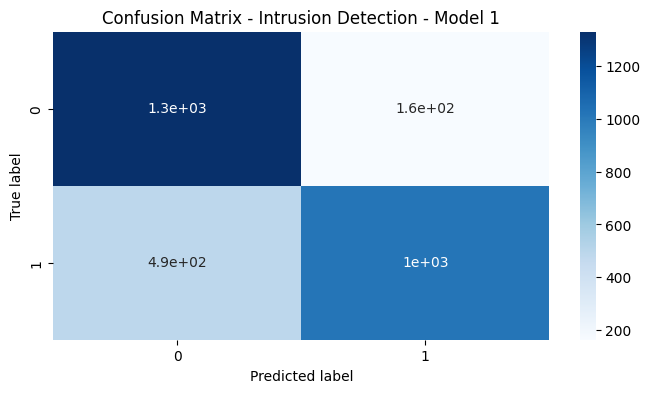

In [29]:
y_pred_lr1 = lr1.predict(X_test)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_lr1)

fig, axs = plt.subplots(1, 1, figsize = (8, 4))

sns.heatmap(conf_matrix_model1, annot=True, cmap='Blues', ax=axs)
axs.set_title('Confusion Matrix - Intrusion Detection - Model 1')
axs.set_xlabel('Predicted label')
axs.set_ylabel('True label')
plt.show()

Next, we evaluate our model using the **ROC curve**. The ROC curve shows the trade-off between the **True Positive Rate (Recall)** and the **False Positive Rate**.

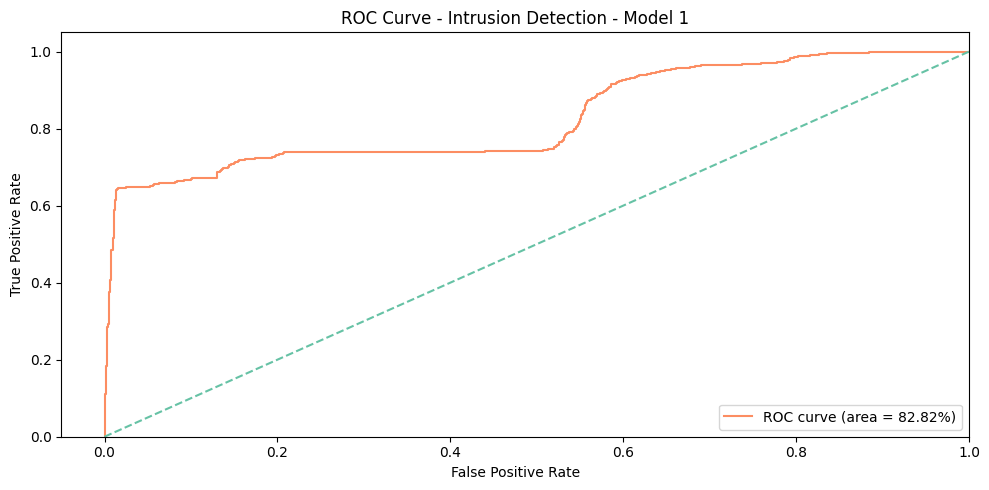

In [22]:
y_prob_lr1 = lr1.predict_proba(X_test)[:, 1]

fpr1, tpr1, _ = roc_curve(y_test, y_prob_lr1)
roc_auc1 = auc(fpr1, tpr1)

colors = sns.color_palette('Set2', n_colors=3)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(fpr1, tpr1, label=f'ROC curve (area = {roc_auc1:.2%})', color=colors[1])
ax.plot([0, 1], [0, 1], color=colors[0], linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Intrusion Detection - Model 1')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In this step, we analyze our Logistic Regression model’s performance using its **Precision**, **Recall**, and **F1-score** values for each class. We generate a classification report and visualize these metrics as a heatmap to understand how well the model detects **benign** and **attack** network traffic.

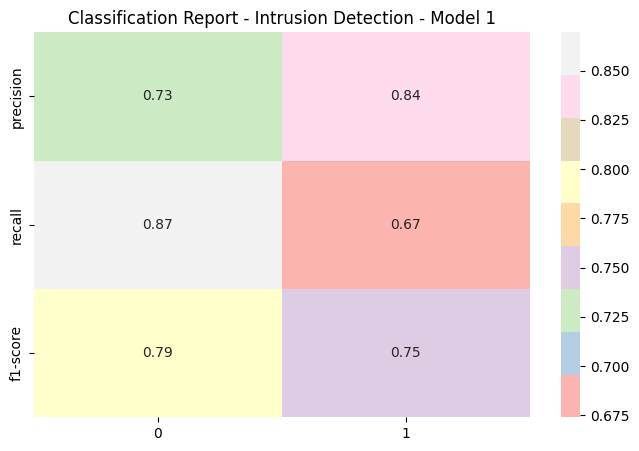

In [23]:
target_names = lr1.classes_
metrics1 = classification_report(y_true = y_test, y_pred = y_pred_lr1, target_names = target_names, output_dict = True)

precision1 = [metrics1[target]['precision'] for target in target_names]
recall1 = [metrics1[target]['recall'] for target in target_names]
f1_score1 = [metrics1[target]['f1-score'] for target in target_names]

data1 = np.array([precision1, recall1, f1_score1])
rows = ['precision', 'recall', 'f1-score']

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(data1, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows, ax=ax)
ax.set_title('Classification Report - Intrusion Detection - Model 1')
plt.show()


## ⬇️ Model Performance Review

The initial model results are **not as good as expected** — accuracy remains relatively low and the predictions are inconsistent.  
This suggests that our data might not be properly prepared for the model to learn effectively.

To improve performance, we’ll **return to the data preprocessing stage** and apply additional steps such as:
- **Feature scaling (standardization)** to ensure all features are on the same scale.  
- **Dimensionality reduction (PCA)** to remove noise and redundant information.

These steps often help linear models like Logistic Regression perform better by making the feature space more balanced and easier to separate.


## ⬇️ StandardScaler

Different features (e.g., `Flow Duration`, `Packet Size`, `Bytes/s`) can have very different ranges. Since logistic regression is sensitive to feature scale, unscaled data can cause numerical instability, overflow errors, slow or failed model convergence.

**StandardScaler** standardizes each feature to have: $$\text{mean} = 0 \quad \text{and} \quad \text{standard deviation} = 1$$

This ensures all features contribute on a comparable scale.

## ⬇️ PCA (Principal Component Analysis)

Even after scaling, many network features are highly correlated or noisy. **PCA** helps by transforming them into a smaller set of **uncorrelated components** that preserve most of the dataset’s variance.

Benefits of PCA:
- Reduces multicollinearity  
- Removes redundant information  
- Stabilizes optimization for Logistic Regression  
- Speeds up training and improves generalization

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

# Separate features and target
X = data.drop('Attack Type', axis=1)
y = data['Attack Type']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=0)),
    ('lr', LogisticRegression(max_iter=10_000, C=0.1, solver='saga', random_state=0))
])

# Cross-validation on train set only
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
print("Logistic Regression (Scaling + PCA) — Cross-validation")
print("Scores:", ", ".join(f"{s:.3f}" for s in cv_scores))
print(f"Mean CV: {cv_scores.mean():.3f}")

Logistic Regression (Scaling + PCA) — Cross-validation
Scores: 0.991, 0.988, 0.991, 0.984, 0.992
Mean CV: 0.989


In [25]:
# Fit on train set, evaluate on test set
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", f"{acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.989

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1494
           1       1.00      0.98      0.99      1506

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



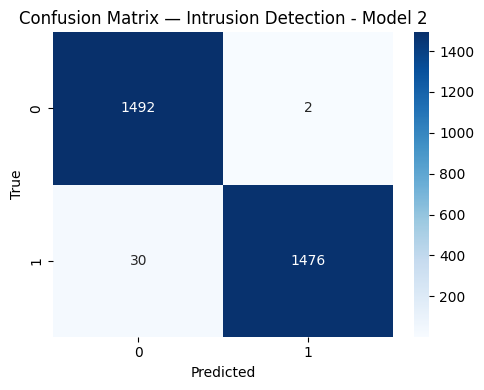

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix — Intrusion Detection - Model 2')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

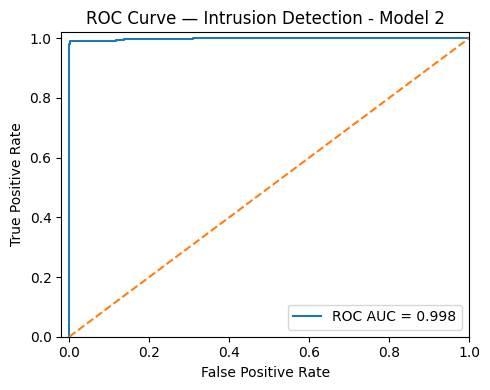

In [27]:
# ROC curve
y_prob = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Intrusion Detection - Model 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

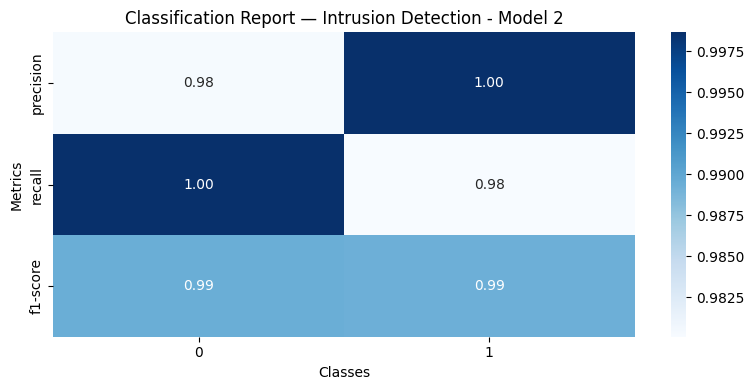

In [28]:
# Classification report as heatmap
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')
report_df_t = report_df.iloc[:, :3].T

plt.figure(figsize=(8, 4))
sns.heatmap(report_df_t, annot=True, fmt=".2f", cmap="Blues")
plt.title("Classification Report — Intrusion Detection - Model 2")
plt.xlabel("Classes")
plt.ylabel("Metrics")
plt.tight_layout()
plt.show()

## ⬇️ The Importance of Scaling and PCA in Model Performance

Our initial model results showed relatively low accuracy and inconsistent predictions.  
After applying feature scaling and **Principal Component Analysis (PCA)**, the model’s performance improved significantly.  
Here’s why these steps make such a big difference:

#### 1. Feature Scaling
- Many machine learning algorithms, including **Logistic Regression**, are sensitive to the scale of input features.  
- Features with larger numeric ranges can dominate the model’s learning process, causing biased weight estimation.  
- By standardizing all features (mean = 0, standard deviation = 1), we ensure that every variable contributes equally to the model.

#### 2. Principal Component Analysis (PCA)
- Real-world datasets often contain redundant or highly correlated features.  
- PCA reduces this redundancy by projecting data into a smaller set of uncorrelated components that capture the majority of the variance.  
- This simplifies the learning process, reduces noise, and helps the model find clearer decision boundaries.

Together, these preprocessing steps help the model **generalize better**, avoid overfitting, and achieve higher accuracy.
